#  Counting Aligned Shapes


An example of a single-layer Convolutional Neural network with a **poisson** loss in a **counting** problem.

## Preliminaries

### Imports

In [1]:
import pickle

import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

import sys


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#
from tensorflow.keras.backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)

sess = tf.Session(config=config)

set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
data_dir="../../data/shapes"
model_dir="../../data/models/tf/Color_Shapes"

In [4]:
filename=data_dir+"/color_shapes.p"
file=open(filename,"rb")
images,data= pickle.load(file)


filename_test=data_dir+"/color_shapes_test.p"
file_test=open(filename_test,"rb")
images_test,data_test= pickle.load(file_test)  

print(images.shape,data.shape,images_test.shape,data_test.shape)

(10000, 100, 100, 3) (10000,) (10000, 100, 100, 3) (10000,)


In [5]:
data[0]

,colors,shapes,center_x,center_y
0,cyan,circle,17,17
1,cyan,rectangle,52,67
2,yellow,rectangle,82,61
3,yellow,triangle,10,39
4,brown,circle,29,68
5,yellow,circle,58,19
6,cyan,triangle,80,22
7,cyan,circle,58,82


In [6]:
colors=["yellow","brown","cyan"]
shapes=["rectangle","circle","triangle"]

In [7]:
k=len(colors)*len(shapes)

In [8]:
df=data[0]
color="red"
shape="rectangle"
len(df[df["colors"]==color]),# & (df['shapes']==shape) ])
len(df[df["shapes"]==shape])

2

In [9]:
def compute_label(df):
    counts=np.zeros((len(colors),len(shapes)),dtype=np.int)
    if df.empty or (df is None):
        return counts
    for i1,color in enumerate(colors):
        for i2,shape in enumerate(shapes):
            counts[i1,i2]=len(df[(df["colors"]==color) & (df['shapes']==shape) ])
            #print (color,shape,counts[i1,i2])
    return counts
compute_labels=np.vectorize(compute_label)

In [10]:
compute_label(data[0])

array([[1, 1, 1],
       [0, 1, 0],
       [1, 2, 1]])

In [11]:
def compute_labels(data):
    labels=[]
    for i1,df in enumerate(data):
        #print(i1)
        labels.append(compute_label(df))
    return np.array(labels)

In [12]:
labels=compute_labels(data)
labels.shape

(10000, 3, 3)

In [13]:
labels_test=compute_labels(data_test)
labels_test.shape

(10000, 3, 3)

In [14]:
labels=labels.reshape(-1,k)
labels_test=labels_test.reshape(-1,k)
print(labels.shape,labels_test.shape)

(10000, 9) (10000, 9)


## Helper Functions

In [15]:
class ReportCallback(keras.callbacks.Callback):
    def __init__(self,frequency,use_val=False):
        self.freq=frequency
        self.use_val=use_val
        self.separator=" || "
        if not(self.use_val):
            self.separator="\n"
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % self.freq ==0):
            train_loss=logs["loss"]
            train_error=logs["count_err"]
            print(f"\t{epoch}: TRAIN Loss {train_loss:.4f},  Err {train_error:.4f}",end=self.separator)
            if self.use_val:
                val_loss=logs["val_loss"]
                val_error=logs["val_count_err"]
                print(f"VAL Loss {val_loss:.4f}, Err {val_error:.4f}")

In [16]:
def count_err(y_true, y_pred):
    return K.sum(K.abs(K.round(y_pred)-y_true),axis=-1)

In [17]:
def count_error(y_pred,y):
    return np.sum(np.abs(np.round(y_pred)-np.round(y)))/len(y)

## Model Selection

### Convolution Only

In [33]:
optimizer=tf.train.AdamOptimizer(learning_rate=0.0005)

In [34]:
model1 = keras.Sequential([
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(100, 100)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [35]:
model1.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [36]:
hist1=model1.fit(images,labels,epochs=1000,validation_split=0.2,verbose=0,callbacks=[ReportCallback(10)])

	0: TRAIN Loss 0.9022,  Err 6.5350
	10: TRAIN Loss 0.7769,  Err 5.4096
	20: TRAIN Loss 0.7174,  Err 4.5036
	30: TRAIN Loss 0.6799,  Err 3.8705
	40: TRAIN Loss 0.6484,  Err 3.1987
	50: TRAIN Loss 0.6362,  Err 2.7969
	60: TRAIN Loss 0.6306,  Err 2.6354
	70: TRAIN Loss 0.6272,  Err 2.5554
	80: TRAIN Loss 0.6234,  Err 2.4706
	90: TRAIN Loss 0.6193,  Err 2.3794
	100: TRAIN Loss 0.6165,  Err 2.3148
	110: TRAIN Loss 0.6123,  Err 2.2110
	120: TRAIN Loss 0.6101,  Err 2.1146
	130: TRAIN Loss 0.6087,  Err 2.0366
	140: TRAIN Loss 0.6070,  Err 1.9616
	150: TRAIN Loss 0.6062,  Err 1.9080
	160: TRAIN Loss 0.6059,  Err 1.8795
	170: TRAIN Loss 0.6049,  Err 1.8176
	180: TRAIN Loss 0.6050,  Err 1.8217
	190: TRAIN Loss 0.6047,  Err 1.8242
	200: TRAIN Loss 0.6054,  Err 1.8444
	210: TRAIN Loss 0.6039,  Err 1.7594
	220: TRAIN Loss 0.6052,  Err 1.8068
	230: TRAIN Loss 0.6049,  Err 1.8296
	240: TRAIN Loss 0.6043,  Err 1.7982
	250: TRAIN Loss 0.6045,  Err 1.8034
	260: TRAIN Loss 0.6046,  Err 1.8164
	270: TRAIN 

###  Two layers on Convolution

In [37]:
model2 = keras.Sequential([
    
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(50, 50)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [38]:
model2.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [39]:
hist2=model2.fit(images,labels,epochs=1000,validation_split=0.2,verbose=0,callbacks=[ReportCallback(10)])

	0: TRAIN Loss 0.8469,  Err 6.0596
	10: TRAIN Loss 0.6438,  Err 2.8964
	20: TRAIN Loss 0.6059,  Err 1.7463
	30: TRAIN Loss 0.6051,  Err 1.6945
	40: TRAIN Loss 0.6033,  Err 1.7144
	50: TRAIN Loss 0.6027,  Err 1.7357
	60: TRAIN Loss 0.6040,  Err 1.7595
	70: TRAIN Loss 0.6018,  Err 1.7534
	80: TRAIN Loss 0.6025,  Err 1.7359
	90: TRAIN Loss 0.6023,  Err 1.7304
	100: TRAIN Loss 0.6017,  Err 1.7230
	110: TRAIN Loss 0.6013,  Err 1.7130
	120: TRAIN Loss 0.6009,  Err 1.7124
	130: TRAIN Loss 0.6009,  Err 1.7175
	140: TRAIN Loss 0.6007,  Err 1.7139
	150: TRAIN Loss 0.6017,  Err 1.7448
	160: TRAIN Loss 0.6006,  Err 1.7196
	170: TRAIN Loss 0.6001,  Err 1.7328
	180: TRAIN Loss 0.5994,  Err 1.6956
	190: TRAIN Loss 0.5996,  Err 1.7009
	200: TRAIN Loss 0.5993,  Err 1.6714
	210: TRAIN Loss 0.5991,  Err 1.6898
	220: TRAIN Loss 0.5988,  Err 1.6826
	230: TRAIN Loss 0.5996,  Err 1.7125
	240: TRAIN Loss 0.5992,  Err 1.6884
	250: TRAIN Loss 0.5990,  Err 1.6771
	260: TRAIN Loss 0.5987,  Err 1.6854
	270: TRAIN 

### Convolution plus dense layer

In [40]:

model3 = keras.Sequential([
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(100, 100)),
   
    # Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [41]:
model3.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [42]:
hist3=model3.fit(images,labels,epochs=1000,validation_split=0.2,verbose=0,callbacks=[ReportCallback(10)])

	0: TRAIN Loss 0.8646,  Err 6.1151
	10: TRAIN Loss 0.6157,  Err 2.8333
	20: TRAIN Loss 0.5474,  Err 1.6944
	30: TRAIN Loss 0.5169,  Err 1.3526
	40: TRAIN Loss 0.4841,  Err 0.8522
	50: TRAIN Loss 0.4564,  Err 0.4124
	60: TRAIN Loss 0.4473,  Err 0.3114
	70: TRAIN Loss 0.4417,  Err 0.2405
	80: TRAIN Loss 0.4377,  Err 0.1999
	90: TRAIN Loss 0.4340,  Err 0.1487
	100: TRAIN Loss 0.4298,  Err 0.0989
	110: TRAIN Loss 0.4232,  Err 0.0483
	120: TRAIN Loss 0.4198,  Err 0.0305
	130: TRAIN Loss 0.4183,  Err 0.0217
	140: TRAIN Loss 0.4178,  Err 0.0255
	150: TRAIN Loss 0.4169,  Err 0.0156
	160: TRAIN Loss 0.4166,  Err 0.0143
	170: TRAIN Loss 0.4165,  Err 0.0136
	180: TRAIN Loss 0.4167,  Err 0.0149
	190: TRAIN Loss 0.4171,  Err 0.0159
	200: TRAIN Loss 0.4163,  Err 0.0088
	210: TRAIN Loss 0.4163,  Err 0.0083
	220: TRAIN Loss 0.4163,  Err 0.0085
	230: TRAIN Loss 0.4168,  Err 0.0140
	240: TRAIN Loss 0.4163,  Err 0.0066
	250: TRAIN Loss 0.4164,  Err 0.0076
	260: TRAIN Loss 0.4162,  Err 0.0051
	270: TRAIN 

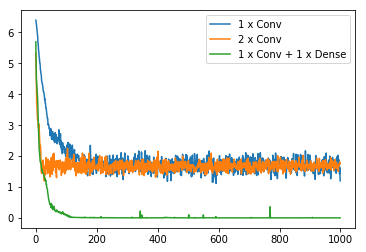

In [43]:
plt.plot(hist1.history["val_count_err"],label="1 x Conv")
plt.plot(hist2.history["val_count_err"],label="2 x Conv")
plt.plot(hist3.history["val_count_err"],label="1 x Conv + 1 x Dense")
plt.legend()

##  Model Test

In [45]:

model = keras.Sequential([
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(100, 100)),
   
    # Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [46]:
model.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
average_pooling2d_5 (Average (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 585       
_________________________________________________________________
lambda_6 (Lambda)            (None, 9)                 0         
Total params: 3,593
Trainable params: 3,593
Non-trainable params: 0
_________________________________________________________________


In [48]:
hist=model.fit(images,labels,epochs=1000,verbose=0,callbacks=[ReportCallback(10,False)])

	0: TRAIN Loss 0.8510,  Err 5.9778
	10: TRAIN Loss 0.6148,  Err 2.7052
	20: TRAIN Loss 0.5600,  Err 1.7910
	30: TRAIN Loss 0.5202,  Err 1.2637
	40: TRAIN Loss 0.4777,  Err 0.6039
	50: TRAIN Loss 0.4588,  Err 0.3997
	60: TRAIN Loss 0.4486,  Err 0.3106
	70: TRAIN Loss 0.4424,  Err 0.2645
	80: TRAIN Loss 0.4365,  Err 0.1961
	90: TRAIN Loss 0.4312,  Err 0.1326
	100: TRAIN Loss 0.4271,  Err 0.0919
	110: TRAIN Loss 0.4237,  Err 0.0636
	120: TRAIN Loss 0.4213,  Err 0.0504
	130: TRAIN Loss 0.4202,  Err 0.0497
	140: TRAIN Loss 0.4196,  Err 0.0440
	150: TRAIN Loss 0.4194,  Err 0.0436
	160: TRAIN Loss 0.4192,  Err 0.0427
	170: TRAIN Loss 0.4192,  Err 0.0382
	180: TRAIN Loss 0.4185,  Err 0.0313
	190: TRAIN Loss 0.4198,  Err 0.0404
	200: TRAIN Loss 0.4187,  Err 0.0357
	210: TRAIN Loss 0.4181,  Err 0.0298
	220: TRAIN Loss 0.4182,  Err 0.0320
	230: TRAIN Loss 0.4176,  Err 0.0244
	240: TRAIN Loss 0.4175,  Err 0.0207
	250: TRAIN Loss 0.4315,  Err 0.0680
	260: TRAIN Loss 0.4173,  Err 0.0161
	270: TRAIN 

In [50]:
Y_pred=model.predict(images_test)

In [51]:

count_error(Y_pred,labels_test)

0.0081

yellow rectangle 0 0.0
yellow circle 3 3.0
yellow triangle 2 2.0
brown rectangle 1 1.0
brown circle 1 1.0
brown triangle 2 2.0
cyan rectangle 1 1.0
cyan circle 0 0.0
cyan triangle 0 0.0


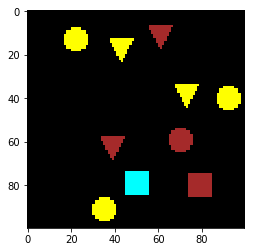

In [53]:
idx=3104
for i1,color in enumerate(colors):
        for i2,shape in enumerate(shapes):
            k=i1*len(shapes)+i2
            print(color,shape,labels_test[idx,k],round(Y_pred[idx,k]))
plt.imshow(images_test[idx])